## Tinder 4 Movies

In [73]:
# import functions
from p import stemming_tokenizer, recommendations_final, recommendations

# import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Daten einlesen & bereinigen
Wir lesen hier die Dateien ein und führen sie zusammen anhand der tmdbId --> So bekommen wir die entsprechende movieIds

In [74]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


Hier extrahieren wir die relevanten Daten aus den angegebenen Spalten, weil sie dort verschachtelt sind.

In [75]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

Hier haben wir die Spalten definiert und geordnet, die wir benötigen (alle anderen wurden automatisch entfernt)

In [76]:
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "release_date", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
]

df_movies = df_movies[col_order]

Hier wurden die Daten weiter bereinigt

In [77]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df_movies = df_movies.drop_duplicates(subset = df_movies.columns.difference(["movieId"]))

# drop rows with runtime 30 --> remove short films because they are not relevant in our opinion
df_movies = df_movies.drop(df_movies[df_movies["runtime"] < 30].index)

# remove all overviews that are nan
df_movies = df_movies.dropna(subset=["overview"])

In [78]:
df_movies

,movieId,title,genres,overview,release_date,runtime,original_language,spoken_languages,production_companies,production_countries
0,895,Venice,Drama|Romance,An atmospheric coming-of-age story featuring a...,2010-06-11,110,pl,Český|Deutsch|Polski|Pусский,Akson Studio|ITI Cinema,Poland
6,2679,A Place at the Table,Documentary,"Using personal stories, this powerful document...",2012-03-22,84,en,English,,United States of America
11,4249,Kingdom Come,Comedy|Documentary,"The documentary, Kingdom Come follows a first-...",2011-01-01,88,en,,,
12,4484,"Camille Claudel, 1915",Drama,"Winter, 1915. Confined by her family to an asy...",2013-03-13,95,fr,Français,ARTE France Cinéma|Canal+|3B Productions|Picta...,France
16,5904,My Kingdom,Drama|Action|Romance,"In the 19th century, the Prince Regent of the ...",2011-09-08,95,zh,广州话 / 廣州話|普通话,,China
...,...,...,...,...,...,...,...,...,...,...
19973,209133,The Riot and the Dance: Earth,Documentary,"This nature/science documentary, showcases the...",2018-03-19,110,en,,,
19974,209143,The Painting,Documentary|History|Animation,"For three and a half centuries, from the same ...",2019-11-08,107,es,English|Français|Italiano|Español,TVE|TeleMadrid|Mare Films,Spain
19975,209145,Liberte,Drama|History,"1774, shortly before the French Revolution, so...",2019-09-04,132,fr,Français|Italiano|Deutsch,CNC|Medienboard Berlin-Brandenburg|Idéale Audi...,Germany|Spain|France|Portugal
19977,209157,We,Drama,During a scorching summer in a Belgian-Dutch b...,2018-07-12,100,nl,Nederlands,New AMS Film Company,Belgium|Netherlands


#### Movie Ratings
Hier lesen wir die Filmbewertungen ein. Wir haben Filme von der TMDB API abgefragt und gespeichert und wir wollen jetzt nur die bewerteten Filme behalten. Darum schauen wir, ob die movieIds übereinstimmen, falls ja dann werden diese Bewertungen beibehalten. Alle andere Bewertungen werden automatisch gelöscht, da sie irrelevant sind.

Danach werden weitere Bereinigungsmethoden angewendet, wie den Timestamp zu konvertieren und die beiden Dataframes zusammenzufügen.

So können wir dann Bewertungen plausibilisieren --> falls diese Daten unmöglich sind (zb eine Bewertung wurde vor der Veröffentlichung vom Film erstellt), werden sie gelöscht.

In [79]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [80]:
# only keep movie ratings where the movieId is in df_movies
df_ratings = df_ratings[df_ratings["movieId"].isin(list(df_movies["movieId"]))]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings on movieId
df_movies_ratings = pd.merge(df_ratings, df_movies, on = "movieId")

# drop rows where the ratings were submitted before the movie released
df_movies_ratings = df_movies_ratings[df_movies_ratings["date"] > df_movies_ratings["release_date"]]

# drop columns because they are useless now
df_movies_ratings.drop(["date", "release_date"], axis = 1, inplace = True)

Hier ist ein weiteres Beispiel von Daten zu plausibilisieren.

In [10]:
# No user has rated the same movie twice
df_movies_ratings[df_movies_ratings.duplicated(subset = ["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,runtime,original_language,spoken_languages,production_companies,production_countries


Export von Datenbanken für seperates EDA ipynb

In [ ]:
df_movies_ratings.to_csv('ml-25m/df_movie_ratings.csv', index=False)

### NLP Implementierung

Was macht tf-idf mit Wörter, die überall vorkommen? 
- diese Wörter werden tief gewichtet

Was passiert mit Wörter die sehr selten sind? kann das Wort überahupt zur Ähnlichkeit beitragen?
- Wörter, die selten vorkommen haben ein höheres Score (höher bewertet)

Synonyme: Word2Vec (zb Auto --> PKW)

Verteilung der Ähnlichkeiten

aus dem text vektoren machen

was passiert mit dem cosinus similarity wenn wir die seltesten wörter abschneiden? besser? schlechter?

auf grund der häufigkeit matrix reduzieren

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

Source: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

 Welche Attribute wollen wir für die Berechnung verwenden?
- Titel
- Overview
- Original Language
- Spoken Language
- Production Companies
- Production Countries

Für grössere Funktionen haben wir einen "helper" Datei erstellt und importieren die Funktionen.

Bevor man mit einem NLP Algorithmus beginnt, müssen die Daten zuerst darauf vorbereitet werden (Pre-processed) - Dafür haben wir eine Funktion "stemming_tokenizer" erstellt, die verschiedene Varianten eines Wortes auf ihren gemeinsamen Wortstamm zurückführt. Somit können einzelne Wörter und auch ganze Texte besser verglichen werden. Diese Funktion löscht zudem auch noch unnötige Symbole wie Kommas und Punkte und auch noch "stop words". Das sind z.B. Wörter wie "the", "a" ect.

In [19]:
# copy dataframe to avoid running the whole notebook again
df_movies_nlp = df_movies.copy().reset_index(drop = True)

# loop through the chosen columns and stem the words
for col in ["overview", "spoken_languages", "original_language", "production_companies", "production_countries"]:
    df_movies_nlp[col] = stemming_tokenizer(df_movies_nlp[col])

# create new title column with stemmed title (we don't want to stem the original title)
df_movies_nlp["new_title"] = stemming_tokenizer(df_movies_nlp["title"])

Wir programmieren eine Funktion, welche zufällig die Anzahl angegebene Spalten hinzufügt, um systematisch herauszufinden, welche Kombination von Spalten (Daten) die höchsten Scores / besten Vorschläge für die Filme hat. Die Funktion heisst "create_combinations" und ist im File "helper_file.py"

Hier rufen wir die Funktion auf und dabei wird ein Dataframe erstellt, die alle Filme mit 10 Filmvorschlägen ausgibt. Das Dataframe wird danach als csv exportiert und wieder eingelesen, damit wir die Funktion nicht immer ausführen müssen.

In [20]:
#df_recommendations = recommendations(df_movies_nlp, df_movies)

#df_recommendations.sort_values(by = ["movie", "score_1"], ascending = False)

# export dataframe to csv
#df_recommendations.to_csv("rec.csv", index = False)

In [21]:
rec = pd.read_csv("rec.csv", index_col = "Unnamed: 0")
rec.head()

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,recommended_movie_6,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10
0,"['new_title', 'overview', 'spoken_languages', ...",Venice,Panic Attack,0.154583,7 Things You Don't Know About Men,0.148710,Embassy,0.148499,Letters to Santa,0.139134,...,Women of Mafia 2,0.137449,Gods,0.134155,Hardkor Disko,0.130372,Breakfast in Bed,0.130297,Walpurgis Night,0.129467
1,"['new_title', 'overview', 'spoken_languages', ...",A Place at the Table,Food and Shelter,0.229952,Food Stamped,0.085962,The Anonymous People,0.084057,Mixed Doubles,0.074443,...,Food Choices,0.071564,Farmageddon,0.063199,Growing Cities,0.062772,Eating Animals,0.062322,Permanent,0.061547
2,"['new_title', 'overview', 'spoken_languages', ...",Kingdom Come,"Chronic-Con, Episode 420: A New Dope",0.069982,Kingdom Come,0.069428,Kevin Smith: Too Fat For 40,0.061588,Rats,0.052913,...,Barbie: Princess Charm School,0.047550,The Special Relationship,0.045128,"The Death of ""Superman Lives"": What Happened?",0.045053,Selma,0.042078,Wonder,0.042025
3,"['new_title', 'overview', 'spoken_languages', ...","Camille Claudel, 1915",Rodin,0.173721,Ducoboo 2: Crazy Vacation,0.124234,Oh Mercy,0.117102,Camille Rewinds,0.108202,...,Trophy Wife,0.096784,School Life,0.093823,House of Pleasures,0.091848,Eva,0.091395,My Golden Days,0.090107
4,"['new_title', 'overview', 'spoken_languages', ...",My Kingdom,White Vengeance,0.098080,The Final Master,0.080325,The Looming Storm,0.069230,Touch of the Light,0.066363,...,Buddha Mountain,0.058536,Bangkok Revenge,0.057755,The Black Devil and the White Prince,0.057549,Sword Master,0.056973,Master Z: Ip Man Legacy,0.056659


Wir erstellen hier eine neue Spalte, um die unique Kombinationen indexieren zu können.

In [22]:
# create new column based on groupby combinations
rec["set_combination"] = rec.groupby("combination").ngroup()
rec["set_combination"].head()

0    9
1    9
2    9
3    9
4    9
Name: set_combination, dtype: int64

Von allen Kombinationen zeigen wir die Verteilung von den Scores vom Recommended Movie 1

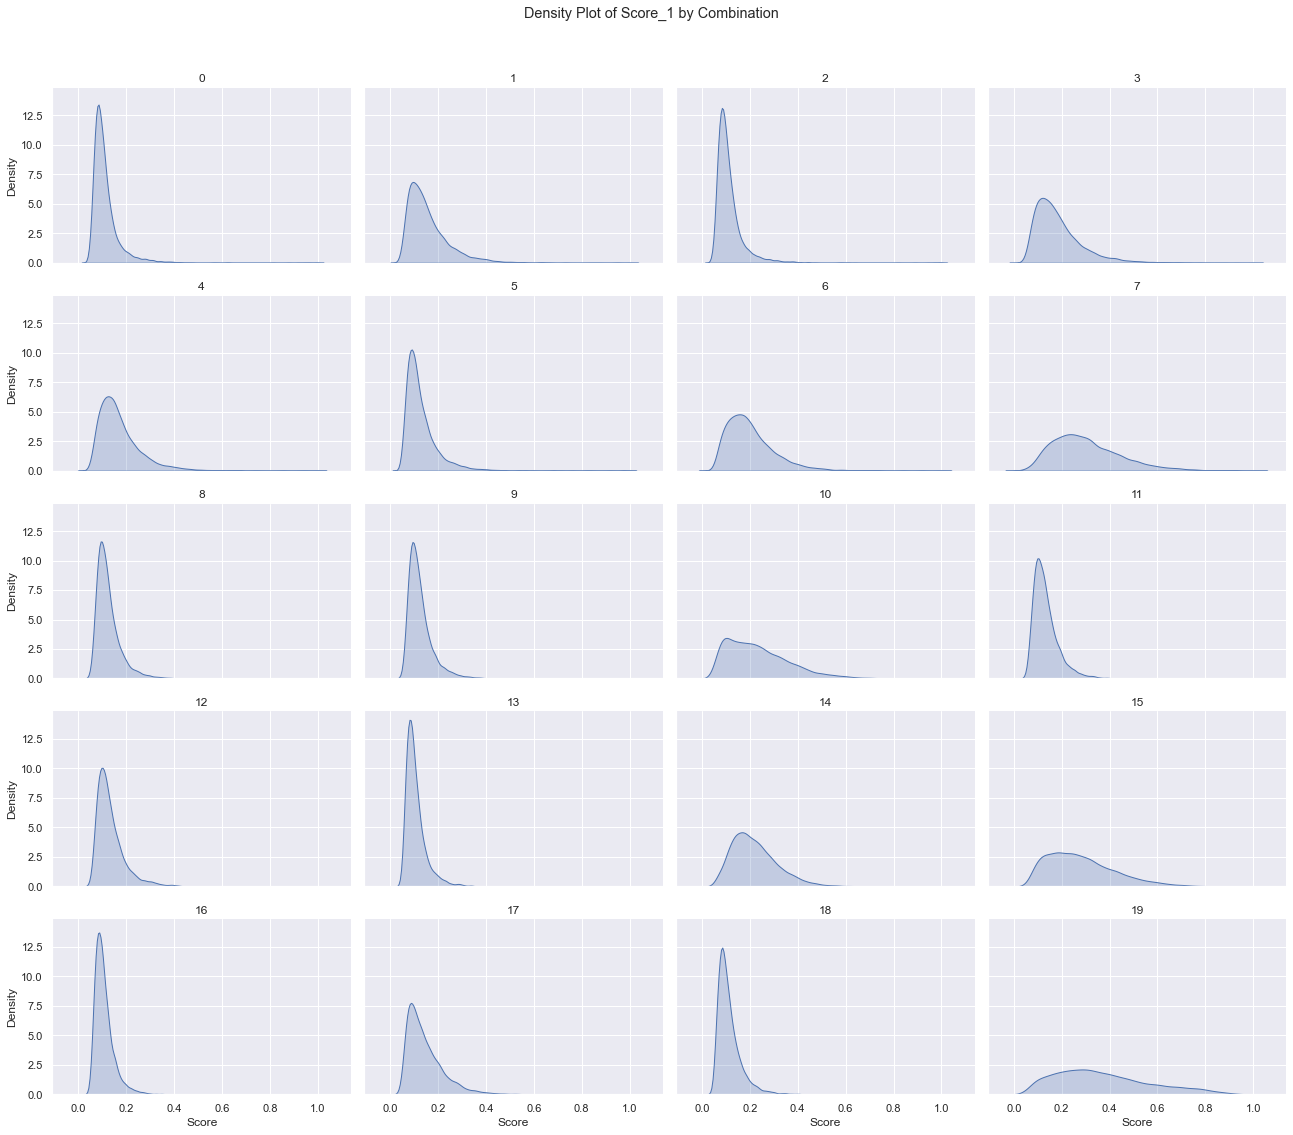

In [23]:
# facet wrap density plot for each combination
g = sns.FacetGrid(rec, col = "set_combination", col_wrap = 4, height = 3, aspect = 1.5)
g.map(sns.kdeplot, "score_1", shade = True)
g.set_titles(col_template = "{col_name}")
g.set_axis_labels("Score", "Density")
g.fig.suptitle("Density Plot of Score_1 by Combination", y = 1.05)
plt.show()

In [24]:
# create subset for "fast & furious 6"
rec_fast6 = rec[rec["movie"] == "Fast & Furious 6"]

# display row with the highest score_1
rec_fast6[rec_fast6["score_1"] == rec_fast6["score_1"].max()]

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
20788,"['new_title', 'overview', 'spoken_languages', ...",Fast & Furious 6,Furious 7,0.452835,The Fate of the Furious,0.442821,Fast Five,0.38839,Trainwreck,0.387489,...,0.371084,The Secret Life of Pets 2,0.301981,Survival Family,0.271846,"Rich Man, Poor Woman in New York",0.260465,Battle: Los Angeles,0.246985,19


Hier wollen wir stets schauen, welche Wörter in allen Overviews am häufigsten vorkommen.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer --> convert a collection of text documents to a vector of term / token counts
count_vectorizer = CountVectorizer(stop_words="english", analyzer = "word", ngram_range=(1, 2))

word_count_matrix = count_vectorizer.fit_transform(df_movies_nlp["overview"])
word_array = count_vectorizer.get_feature_names_out()

print([word_array[i] for i in np.argsort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5]])
print(np.sort(word_count_matrix.sum(axis=0)).tolist()[0][::-1][:5])

['life', 'year', 'live', 'world', 'young']
[4014, 3378, 2879, 2751, 2661]


## LSA
LSA (LAtent Semantic Analysis) auch bekannt als LSI (Latent Semantic Index) verwendet ein- Bag-of-Word-Modell (BoW), das zu einer Term-Dokument-Matrix führt (Vorkommen von Begriffen in einem Dokument)

Die Zeilen stehen für Begriffe und die Spalten für Dokumente. LSA lernt latente Themen, indem eine Matrixzerlegung der Dokument-Term-Matrix unter Verwendung der Singulärwertzerlegung durchgeführt wird. LSA Wird in der Regel zur Dimensionsreduzierung eingesetzt.

### SVD (Singular Value Decomposition) - Singulärwertzerlegung
SVD ist eine Matrixfaktorisierungsmethode, die eine Matrix als Produkt zweier Matrizen darstellt.

A: Input data matrix
m x n matrix (m documents, n terms)

U: Left singular vectors
m x r matrix (m documents, r concepts)

Sigma: Singular values
r x r diagonal matrix

V: Right singular vectors
n x r matrix (n terms, r concepts)

In [26]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def prepare_corpus(data):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(data)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in data]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

## Doc2Vec

In [27]:
### tfidf gewichtung
### word2vec ein vektor für ein einzelnes wort
### embedings und global average
### evaluation: masking ratings from users to test the model

## User Profiles
for every user, take the movies that the user liked (rating 3.5+)
--> search for movies that are similar to the ones this user liked --> recommend 

In [28]:
# get users with more than 20 ratings
users = df_movies_ratings["userId"].value_counts()[df_movies_ratings["userId"].value_counts() > 20].index.tolist()

df_users = df_movies_ratings[df_movies_ratings["userId"].isin(users)]

In [29]:
# print unique users
print("Unique users: ", df_users["userId"].nunique())

Unique users:  26294


In [30]:
# create user-liked-movie matrix with userid as index and movieid as columns and rating as values
df_user_movie_matrix = df_users.pivot(index = "userId", columns = "movieId", values = "rating").fillna(0)

# if rating is greater than 3, set value to 1, else set value to 0
df_user_movie_matrix[df_user_movie_matrix <= 3] = 0
df_user_movie_matrix[df_user_movie_matrix > 3] = 1

df_user_movie_matrix

movieId,895,2679,4249,4484,5904,47237,47962,71677,72491,73319,...,209053,209063,209073,209085,209119,209121,209129,209131,209133,209163
userId,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Mask & Predict

--> Mask a part of the dataset and make predictions

In [48]:
df_user_movie_matrix_masked = df_user_movie_matrix.copy()

Statistische Auswertungen
Wie viele Recommendations sind gut?

HIT, Precision

In [31]:
# get sample from user-movie matrix 
df_user_movie_matrix_sample = df_user_movie_matrix.sample(500, random_state = 42)

In [32]:
# for each user save all movieId where the value is 1
df_user_movie_matrix_sample["liked_movies"] = df_user_movie_matrix_sample.apply(lambda x: x[x == 1].index.tolist(), axis = 1)

# create a list of tuples with (userId, [list of liked movies])
user_movie_list = list(zip(df_user_movie_matrix_sample.index, df_user_movie_matrix_sample["liked_movies"]))

### Samples

In [33]:
import random

# sample 10 movies from user index 0
user_movie_list_sample = random.sample(user_movie_list[0][1], 10)

# get titles from user_movie_list_sample
df_user_movie_list_sample = df_movies_nlp[df_movies_nlp["movieId"].isin(user_movie_list_sample)].reset_index(drop = True)

Von den gesampelten Filmen wollen wir nun die dafür vorgeschlagene Filme anschauen

In [34]:
df_user_movie_list_sample_combination = rec[rec["movie"].isin(df_user_movie_list_sample["title"])]
df_user_movie_list_sample_combination

,combination,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,...,score_6,recommended_movie_7,score_7,recommended_movie_8,score_8,recommended_movie_9,score_9,recommended_movie_10,score_10,set_combination
61,"['new_title', 'overview', 'spoken_languages', ...",Iron Man 2,Iron Man 3,0.179364,Iron Man & Captain America: Heroes United,0.144808,Iron Man & Hulk: Heroes United,0.111815,Marvel Rising: Heart of Iron,0.081821,...,0.076843,Rise of the Superheroes,0.075033,Avengers: Age of Ultron,0.071576,Beside Still Waters,0.057994,Marvel Super Hero Adventures: Frost Fight!,0.057085,9
95,"['new_title', 'overview', 'spoken_languages', ...",Toy Story 3,Toy Story 4,0.221566,Andy Peters: Exclamation Mark Question Point,0.128434,Quarantine L.A.,0.096780,Plastic Galaxy: The Story of Star Wars Toys,0.094130,...,0.090364,Jim & Andy: The Great Beyond,0.088873,A Dark Place Inside,0.084579,Demonic Toys: Personal Demons,0.084152,The Dry Land,0.083904,9
651,"['new_title', 'overview', 'spoken_languages', ...",Warrior,Brothers,0.121308,Hard Target 2,0.119586,Here Comes the Boom,0.108138,Submission,0.096376,...,0.085693,Happy Christmas,0.078742,The Hurt Business,0.078331,Sadece Sen,0.076748,Just Call Me Nobody,0.076089,9
938,"['new_title', 'overview', 'spoken_languages', ...",Wrong Turn 4: Bloody Beginnings,Wrong Turn 5: Bloodlines,0.125552,Polar,0.089697,Wild Oats,0.087658,Wrong Turn 6: Last Resort,0.087260,...,0.077826,Love Ranch,0.075581,London Town,0.073632,Snowden,0.072697,Tarzan,0.072356,9
1131,"['new_title', 'overview', 'spoken_languages', ...",The Amazing Spider-Man,The Amazing Spider-Man 2,0.224044,Spider-Man: Into the Spider-Verse,0.144311,Spider-Man: Far from Home,0.127212,The Fjällbacka Murders: Friends for Life,0.090758,...,0.077490,Mushroomers,0.074522,Heart of Stone,0.070833,One Day Since Yesterday: Peter Bogdanovich & t...,0.067888,Treehouse,0.064913,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361153,"['new_title', 'overview', 'spoken_languages', ...",Pitch Perfect,Yaariyan,0.071203,Mistress America,0.060301,Governor Gabbi,0.057622,Her Composition,0.052845,...,0.049309,A Cinderella Story: If the Shoe Fits,0.047351,Like Crazy,0.046979,Amityville: No Escape,0.046961,100% Love,0.046110,16
361168,"['new_title', 'overview', 'spoken_languages', ...",Resident Evil: Retribution,Resident Evil: Afterlife,0.168795,Resident Evil: The Final Chapter,0.109646,Sinister Squad,0.065338,Young Sophie Bell,0.059670,...,0.057593,Alice in Wonderland,0.053827,Alice Through the Looking Glass,0.052871,Trophy Wife,0.052443,Welcome the Stranger,0.050880,16
361814,"['new_title', 'overview', 'spoken_languages', ...",Man of Steel,K.G.F: Chapter 1,0.093651,The Hunger Games: Mockingjay - Part 1,0.077681,Teenage Mutant Ninja Turtles,0.072947,Prometheus,0.070853,...,0.066059,The Fields,0.063708,Teen Titans: The Judas Contract,0.063442,I Give You My Word,0.062377,The Departure,0.061603,16
362151,"['new_title', 'overview', 'spoken_languages', ...",Thor: The Dark World,Thor,0.155814,Thor: Ragnarok,0.097924,I am Thor,0.097278,Man's First Friend,0.061807,...,0.058346,The Mountain Between Us,0.055985,Dark World: Equilibrium,0.055621,The Wild Goose Lake,0.052994,Where Is Kyra?,0.051143,16


In [35]:
# convert unique combinations to list
old_combinations = df_user_movie_list_sample_combination["combination"].unique()

combinations = []
for i in old_combinations:
    # remove ' from i
    i = i.replace("'", "")
    # replace [ 
    i = i.replace("[", "")
    # replace ]
    i = i.replace("]", "")
    # split
    i = i.split(", ")

    combinations.append(i)

In [36]:
df_user_movie_list_sample_combination["set_combination"] = df_user_movie_list_sample_combination.groupby(df_user_movie_list_sample_combination["combination"].map(tuple)).ngroup()

C:\Users\Alex\AppData\Local\Temp/ipykernel_20688/4184100356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_movie_list_sample_combination["set_combination"] = df_user_movie_list_sample_combination.groupby(df_user_movie_list_sample_combination["combination"].map(tuple)).ngroup()


### Kombination Entscheidung

In [37]:
# print combination where set_combination is 19
df_user_movie_list_sample_combination[df_user_movie_list_sample_combination["set_combination"] == 19]["combination"].unique()

array(["['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']"],
      dtype=object)

Wir entscheiden uns für die Kombination 19, weil die Verteilung die höchsten Werte annimmt. Overview kommt 1 Mal vor, das bedeutet, dass die Wörter im Overview höcher bewertet werden (das Ziel ist es ja eher anhand des Overviews Filme vorzuschlagen)

In [38]:
cols = ['new_title', 'overview', 'spoken_languages', 'original_language', 'production_companies', 'production_countries', 'new_title', 'new_title', 'overview', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'spoken_languages', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'original_language', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_companies', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries', 'production_countries']

In [39]:
recommendations_final(df_movies_nlp, ["Toy Story 3", "Fast & Furious 6"], cols)

,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,recommended_movie_5,score_5
0,Toy Story 3,Incredibles 2,0.774336,Toy Story 4,0.771716,Monsters University,0.771383,Cars 2,0.706643,Inside Out,0.674082
1,Fast & Furious 6,Furious 7,0.452835,The Fate of the Furious,0.442821,Fast Five,0.388390,Trainwreck,0.387489,The Secret Life of Pets,0.381141


In [40]:
recommendations_final(df_movies_nlp, ["Interstellar", "The Hunger Games", "Survival of the Dead"], cols)

,movie,recommended_movie_1,score_1,recommended_movie_2,score_2,recommended_movie_3,score_3,recommended_movie_4,score_4,recommended_movie_5,score_5
0,Interstellar,Inception,0.364040,Dunkirk,0.272820,Pacific Rim,0.220115,Pacific Rim: Uprising,0.207111,The Dark Knight Rises,0.196728
1,The Hunger Games,The Hunger Games: Mockingjay - Part 1,0.667101,The Hunger Games: Catching Fire,0.609926,The Hunger Games: Mockingjay - Part 2,0.421615,One Day,0.250133,"Where'd You Go, Bernadette",0.224213
2,Survival of the Dead,Cold Deck,0.294237,Wet Bum,0.196644,Indian Horse,0.196583,The Dark Stranger,0.189357,All Is Lost,0.180549


Wir haben bemerkt, dass die Recommendations bei Horror nicht so gut funktionieren.